<a href="https://colab.research.google.com/github/dylstuart/streaming_asr/blob/main/asr_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Online ASR with Emformer RNN-T

**Original Authors**: [Jeff Hwang](jeffhwang@meta.com)_, [Moto Hira](moto@meta.com)_
**Modified By**: [Dylan Stuart](dyln.strt@gmail.com)

This notebook shows how to use Emformer RNN-T and streaming API
to perform online speech recognition, and measures various latency metrics of the model.


<div class="alert alert-info"><h4>Note</h4><p>This tutorial requires FFmpeg libraries and SentencePiece.
</div>




## 0. Overview

Performing online speech recognition is composed of the following steps

1. Build the inference pipeline
   Emformer RNN-T is composed of three components: feature extractor,
   decoder and token processor.
2. Format the waveform into chunks of expected sizes.
3. Pass data through the pipeline.



## 1. Install dependencies

torchaudio.io.StreamReader used in this repo requires torchaudio==2.8.0. There may be a dependency mismatch with the pre-installed torchvision on colab, we can ignore as we are not using torchvision.

In [1]:
!pip install torchaudio==2.8.0 sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2

## 2. Preparation




In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import IPython
import matplotlib.pyplot as plt
from torchaudio.io import StreamReader

2.8.0+cu128
2.8.0+cu128


## 3. Construct the pipeline

Pre-trained model weights and related pipeline components are
bundled as :py:class:`torchaudio.pipelines.RNNTBundle`.

We use :py:data:`torchaudio.pipelines.EMFORMER_RNNT_BASE_LIBRISPEECH`,
which is a Emformer RNN-T model trained on LibriSpeech dataset.




In [34]:
bundle = torchaudio.pipelines.EMFORMER_RNNT_BASE_LIBRISPEECH

feature_extractor = bundle.get_streaming_feature_extractor()
decoder = bundle.get_decoder()
token_processor = bundle.get_token_processor()

/usr/local/lib/python3.12/dist-packages/torchaudio/pipelines/rnnt_pipeline.py:335: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  )
/usr/local/lib/python3.12/dist-packages/torchaudio/pipelines/rnnt_pipeline.py:247: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  path = torchaudio.utils.download_asset(self._rnnt_path)
/usr/local/lib/python3.12/dist-packages/torchaudio/pipelines/rnnt_pipeline.py:353: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This depreca

Streaming inference works on input data with overlap.
Emformer RNN-T model treats the newest portion of the input data
as the "right context" — a preview of future context.
In each inference call, the model expects the main segment
to start from this right context from the previous inference call.
The following figure illustrates this.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/emformer_rnnt_context.png">

The size of main segment and right context, along with
the expected sample rate can be retrieved from bundle.




In [21]:
sample_rate = bundle.sample_rate
segment_length = bundle.segment_length * bundle.hop_length
context_length = bundle.right_context_length * bundle.hop_length

print(f"Sample rate: {sample_rate}")
print(f"Main segment: {segment_length} frames ({segment_length / sample_rate} seconds)")
print(f"Right context: {context_length} frames ({context_length / sample_rate} seconds)")

Sample rate: 16000
Main segment: 2560 frames (0.16 seconds)
Right context: 640 frames (0.04 seconds)


## 4. Configure the audio stream

Next, we configure the input audio stream using :py:class:`torchaudio.io.StreamReader`.

For the detail of this API, please refer to the
[StreamReader Basic Usage](./streamreader_basic_tutorial.html)_.




The following audio file was originally published by LibriVox project,
and it is in the public domain.

https://librivox.org/great-pirate-stories-by-joseph-lewis-french/

It was re-uploaded for the sake of the tutorial.




In [22]:
src = "https://download.pytorch.org/torchaudio/tutorial-assets/greatpiratestories_00_various.mp3"

streamer = StreamReader(src)
streamer.add_basic_audio_stream(frames_per_chunk=segment_length, sample_rate=bundle.sample_rate)

print(streamer.get_src_stream_info(0))
print(streamer.get_out_stream_info(0))

SourceAudioStream(media_type='audio', codec='mp3', codec_long_name='MP3 (MPEG audio layer 3)', format='fltp', bit_rate=128000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=44100.0, num_channels=2)
OutputAudioStream(source_index=0, filter_description='aresample=16000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=16000.0, num_channels=2)


/tmp/ipython-input-2138279009.py:3: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  streamer = StreamReader(src)


As previously explained, Emformer RNN-T model expects input data with
overlaps; however, `Streamer` iterates the source media without overlap,
so we make a helper structure that caches a part of input data from
`Streamer` as right context and then appends it to the next input data from
`Streamer`.

The following figure illustrates this.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/emformer_rnnt_streamer_context.png">




In [23]:
class ContextCacher:
    """Cache the end of input data and prepend the next input data with it.

    Args:
        segment_length (int): The size of main segment.
            If the incoming segment is shorter, then the segment is padded.
        context_length (int): The size of the context, cached and appended.
    """

    def __init__(self, segment_length: int, context_length: int):
        self.segment_length = segment_length
        self.context_length = context_length
        self.context = torch.zeros([context_length])

    def __call__(self, chunk: torch.Tensor):
        if chunk.size(0) < self.segment_length:
            chunk = torch.nn.functional.pad(chunk, (0, self.segment_length - chunk.size(0)))
        chunk_with_context = torch.cat((self.context, chunk))
        self.context = chunk[-self.context_length :]
        return chunk_with_context

## 5. Run stream inference

Finally, we run the recognition.

First, we initialize the stream iterator, context cacher, and
state and hypothesis that are used by decoder to carry over the
decoding state between inference calls.




In [35]:
cacher = ContextCacher(segment_length, context_length)

state, hypothesis = None, None

Add a timing utility for latency measurements

In [25]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def timed(section, stats):
    start = perf_counter()
    yield
    elapsed = perf_counter() - start
    stats[section].append(elapsed)

chunk_stats = {
    "feature_extraction": [],
    "model_forward": [],
    "decoder": [],
    "total_chunk": []
}

audio_time = 0.0

Next we, run the inference.

For the sake of better display, we create a helper function which
processes the source stream up to the given times and call it
repeatedly.




In [26]:
stream_iterator = streamer.stream()


def _plot(feats, num_iter, unit=25):
    unit_dur = segment_length / sample_rate * unit
    num_plots = num_iter // unit + (1 if num_iter % unit else 0)
    fig, axes = plt.subplots(num_plots, 1)
    t0 = 0
    for i, ax in enumerate(axes):
        feats_ = feats[i * unit : (i + 1) * unit]
        t1 = t0 + segment_length / sample_rate * len(feats_)
        feats_ = torch.cat([f[2:-2] for f in feats_])  # remove boundary effect and overlap
        ax.imshow(feats_.T, extent=[t0, t1, 0, 1], aspect="auto", origin="lower")
        ax.tick_params(which="both", left=False, labelleft=False)
        ax.set_xlim(t0, t0 + unit_dur)
        t0 = t1
    fig.suptitle("MelSpectrogram Feature")
    plt.tight_layout()


@torch.inference_mode()
def run_inference(num_iter=100):
    global state, hypothesis, audio_time
    chunks = []
    feats = []
    for i, (chunk,) in enumerate(stream_iterator, start=1):
        audio_time += (segment_length / sample_rate)
        segment = cacher(chunk[:, 0])
        with timed("total_chunk", chunk_stats):
          with timed("feature_extraction", chunk_stats):
              features, length = feature_extractor(segment)

          with timed("model_forward", chunk_stats):
              hypos, state = decoder.infer(features, length, 10, state=state, hypothesis=hypothesis)

          hypothesis = hypos
          with timed("decoder", chunk_stats):
              transcript = token_processor(hypos[0][0], lstrip=False)

        print(transcript, end="\r", flush=True)
        chunks.append(chunk)
        feats.append(features)

    # Plot the features
    # _plot(feats, num_iter)
    return # IPython.display.Audio(torch.cat(chunks).T.numpy(), rate=bundle.sample_rate)

Collect statistics for all audio samples in our mini dataset

In [36]:
import glob
# Find all mp3 files in our samples directory
sample_paths = glob.glob("./samples/*.mp3")
print(f"{len(sample_paths)} samples available for processing")
full_dataset_stats = []
full_sample_stats = {"latency": [], "rtf": [], "ttft": []}
for path in sample_paths:

  #Initialize temp statistics structures
  audio_time = 0
  chunk_stats = {
    "feature_extraction": [],
    "model_forward": [],
    "decoder": [],
    "total_chunk": []
  }

  # Reset the cache, state, hypothesis
  cacher = ContextCacher(segment_length, context_length)
  state, hypothesis = None, None

  with timed("latency", full_sample_stats):
    streamer = StreamReader(path)
    streamer.add_basic_audio_stream(frames_per_chunk=segment_length, sample_rate=bundle.sample_rate)
    stream_iterator = streamer.stream()
    run_inference()

  full_dataset_stats.append(chunk_stats)
  print(f"Finished {path}")
  rtf = sum(chunk_stats["total_chunk"]) / audio_time
  full_sample_stats["rtf"].append(rtf)
  full_sample_stats["ttft"].append(chunk_stats["total_chunk"][0])
  print(f"Sum of chunk processing times: {sum(chunk_stats["total_chunk"])}\nAudio file duration: {audio_time}\nRTF: {rtf}")


25 samples available for processing


/tmp/ipython-input-1763407127.py:23: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  streamer = StreamReader(path)


Finished ./samples/spontaneous-speech-koo-56545.mp3
Sum of chunk processing times: 10.538006591002613
Audio file duration: 11.040000000000006
RTF: 0.9545295825183521
Finished ./samples/spontaneous-speech-meh-29814.mp3
Sum of chunk processing times: 9.38714067799765
Audio file duration: 10.720000000000006
RTF: 0.8756661080221683
Finished ./samples/spontaneous-speech-qxp-68369.mp3
Sum of chunk processing times: 10.278458803001286
Audio file duration: 10.560000000000006
RTF: 0.9733389017993637
Finished ./samples/spontaneous-speech-cgg-53497.mp3
Sum of chunk processing times: 8.509762248000698
Audio file duration: 9.440000000000005
RTF: 0.9014578652543107
Finished ./samples/spontaneous-speech-ukv-33660.mp3
Sum of chunk processing times: 11.081606748999093
Audio file duration: 11.360000000000007
RTF: 0.9754935518485112
Finished ./samples/spontaneous-speech-lth-28662.mp3
Sum of chunk processing times: 9.470655592001549
Audio file duration: 10.400000000000006
RTF: 0.9106399607693793
Finished 

Aggregate the statistics taken over all of the audio samples and plot the cdfs of each metric for all of the samples

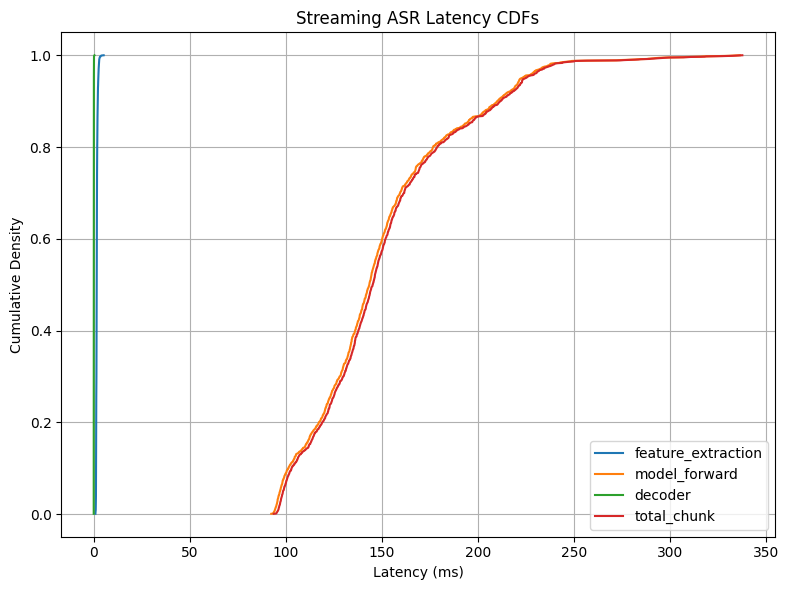

In [38]:
from collections import defaultdict
import numpy as np

def aggregate_dicts(stats_list):
    """
    Flattens a list of dicts into a single dict of arrays.
    """
    aggregated = defaultdict(list)

    for stats in stats_list:
        for key, values in stats.items():
            aggregated[key].extend(values)

    # Convert to numpy arrays for convenience
    return {k: np.array(v) for k, v in aggregated.items()}

def compute_cdf(values):
    """
    Returns sorted values and cumulative probabilities.
    """
    x = np.sort(values)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

# Plot CDF of aggregated stats
aggregated_stats = aggregate_dicts(full_dataset_stats)
metrics = aggregated_stats.keys()
plt.figure(figsize=(8, 6))

for metric in metrics:
    x, y = compute_cdf(aggregated_stats[metric])
    plt.plot(x * 1000, y, label=metric)  # seconds → ms

plt.xlabel("Latency (ms)")
plt.ylabel("Cumulative Density")
plt.title("Streaming ASR Latency CDFs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot sequence of chunk latencies for each sample

Plot Histograms of RTFs and TTFTs

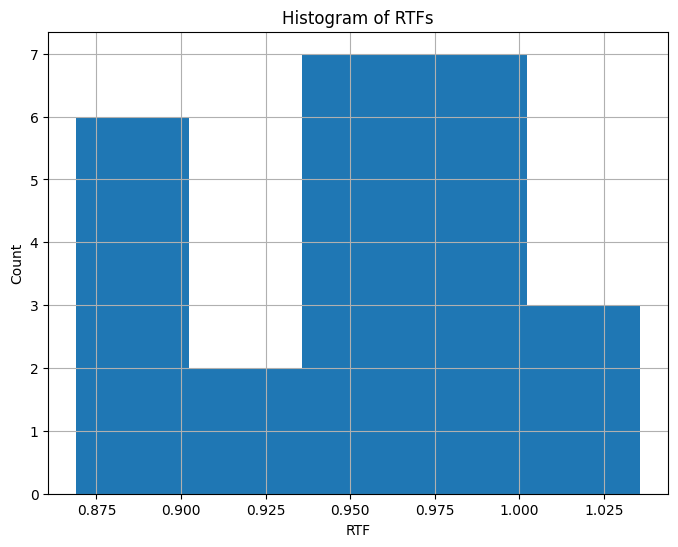

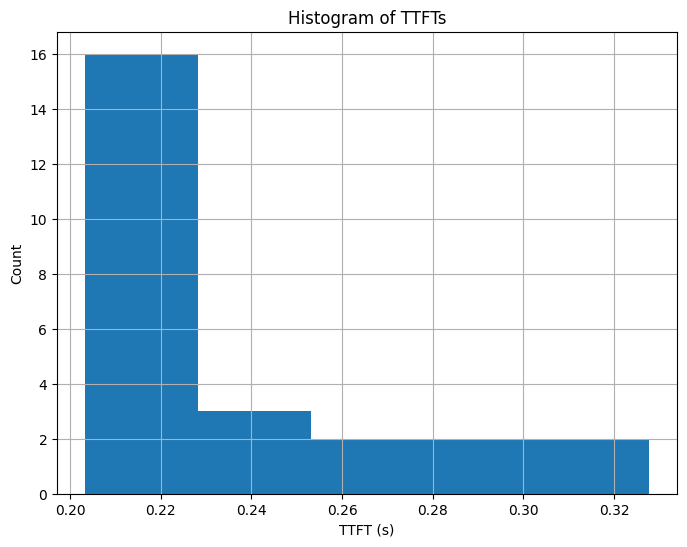

In [37]:
# Plot histogram of RTFs
plt.figure(figsize=(8, 6))
plt.hist(np.array(full_sample_stats["rtf"]), 5)
plt.xlabel("RTF")
plt.ylabel("Count")
plt.title("Histogram of RTFs")
plt.grid(True)
plt.show()

# Plot histogram of TTFTs
plt.figure(figsize=(8, 6))
plt.hist(np.array(full_sample_stats["ttft"]), 5)
plt.xlabel("TTFT (s)")
plt.ylabel("Count")
plt.title("Histogram of TTFTs")
plt.grid(True)
plt.show()